In [1]:
from torch.utils.data import Dataset
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import random
from random import randint
from matern_kernel import matern_kernel_noise_time_batch
import torch.nn.functional as F
from torchmetrics.image import (
    StructuralSimilarityIndexMeasure,
    PeakSignalNoiseRatio,
)
from torchmetrics.functional.image.ssim import (
    structural_similarity_index_measure,
)
from torchmetrics.functional.image.psnr import peak_signal_noise_ratio
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)
g = torch.Generator()
g.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [3]:
def add_matern_kernel_noise_batch(sample, nu=2.5, lengthscale=1.0, sigma=1.0):
    B, T, C, H, W = sample.shape
    x = torch.linspace(0, 1, W, device=sample.device)
    y = torch.linspace(0, 1, H, device=sample.device)
    xx, yy = torch.meshgrid(x, y, indexing="xy")
    coords = torch.stack([xx.flatten(), yy.flatten()], dim=1)
    noise = matern_kernel_noise_time_batch(
        sample=sample,
        coords=coords,
        nu=nu,
        lengthscale=lengthscale,
        sigma=sigma,
    )
    return sample + noise

In [4]:
def resize_encoder(sample):
    sample = F.interpolate(
        sample, size=(144, 72), mode="bicubic", align_corners=False
    )
    return sample


def random_mask(sample, mask_prob_low=0.7, mask_prob_high=0.7):
    if mask_prob_low == mask_prob_high:
        mask_prob = mask_prob_low
    else:
        mask_prob = random.uniform(mask_prob_low, mask_prob_high)
    random_tensor = torch.rand(sample.shape, device=sample.device)
    mask = (random_tensor > mask_prob).float()
    masked_image = sample * mask
    return masked_image


class WeatherBenchDatasetWindow(Dataset):
    def __init__(
        self,
        data,
        context_length,
        target_length,
        stride=1,
        mask_prob_low=0.7,
        mask_prob_high=0.7,
    ):
        self.data = data
        self.context_length = context_length
        self.target_length = target_length
        self.stride = stride
        self.mask_prob_low = mask_prob_low
        self.mask_prob_high = mask_prob_high

    def __len__(self):
        return (
            self.data.shape[0] - (self.context_length + self.target_length)
        ) // self.stride + 1

    def __getitem__(self, idx):
        x = random_mask(
            resize_encoder(self.data[idx : idx + self.context_length]),
            mask_prob_low=self.mask_prob_low,
            mask_prob_high=self.mask_prob_high,
        )
        y = self.data[
            idx
            + self.context_length : idx
            + self.context_length
            + self.target_length
        ]
        y_masked = random_mask(
            resize_encoder(y),
            mask_prob_low=self.mask_prob_low,
            mask_prob_high=self.mask_prob_high,
        )
        return x, y_masked, y

In [5]:
def prepare_inputs(input_data, output_data, encoder_model):
    B, T, C, H, W = input_data.shape
    input_data = input_data.reshape(B * T, C, H, W)
    input_encoded_data, _ = encoder_model(input_data)

    input_encoded_data = input_encoded_data.reshape(B, T, -1)
    B, T, C, H, W = output_data.shape
    output_data = output_data.reshape(B * T, C, H, W)

    output_encoded_data = encoder_model(output_data)[0]
    output_encoded_data = output_encoded_data.reshape(B, T, -1)
    return input_encoded_data, output_encoded_data

In [6]:
# RRMSE
def RRMSE(preds, target):
    mse = torch.mean((preds - target) ** 2)
    rmse = torch.sqrt(mse)
    rrmse = rmse / (target.mean()) * 100
    return rrmse


def RRMSE_per_channel(preds, target):
    rmse = torch.sqrt(torch.mean(((preds - target) ** 2), dim=(2, 3)))
    return rmse / (target.mean(dim=(0, 2, 3))) * 100

In [7]:
def compute_errors(
    testloader,
    encoder_model,
    seq2seq_model,
    decoder_model,
    std,
    mean,
    train_data,
    add_noise=False,
):
    ssim_loss = StructuralSimilarityIndexMeasure(data_range=1.0).to(DEVICE)
    psnr_loss = PeakSignalNoiseRatio(data_range=1.0).to(DEVICE)
    mse_loss = torch.nn.MSELoss()
    preds = []
    targets = []
    mse = []
    latent_mse = []
    ssim = []
    psnr = []
    rel_latent_errors = []
    rel_decoded_errors = []
    for batch in testloader:
        with torch.no_grad():
            if add_noise:
                input_data = add_matern_kernel_noise_batch(
                    batch[0].to(DEVICE)
                )
            else:
                input_data = batch[0].to(DEVICE)
            output_data_masked = batch[1].to(DEVICE)
            output_data = batch[2].to(DEVICE)
            input_encoded_data, output_encoded_data = prepare_inputs(
                input_data, output_data_masked, encoder_model
            )
            model_pred = seq2seq_model(input_encoded_data)
            if model_pred.ndim == 2:
                model_pred = model_pred.unsqueeze(0)
            B, T, L = model_pred.shape
            model_pred = model_pred.reshape(B * T, L)
            output_encoded_data = output_encoded_data.reshape(B * T, L)

            latent_error = mse_loss(model_pred, output_encoded_data)

            decoded_data = decoder_model(model_pred)
            B, T, C, H, W = output_data.shape
            output_data = output_data.reshape(B * T, C, H, W)
            B, T, C, H, W = output_data_masked.shape
            output_data_masked = output_data_masked.reshape(B * T, C, H, W)

            decoded_data_ = decoded_data * std + mean
            output_data_ = output_data * std + mean

            preds.append(decoded_data_)
            targets.append(output_data_)
            mse_l = mse_loss(decoded_data, output_data)

            latent_relative_error = (
                torch.norm(model_pred - output_encoded_data) ** 2
                / torch.norm(output_encoded_data) ** 2
            )
            decoded_relative_error = (
                torch.norm(decoded_data - output_data) ** 2
                / torch.norm(output_data) ** 2
            )

            x_min = train_data.amin(dim=(0, 2, 3), keepdim=True).to(DEVICE)
            x_max = train_data.amax(dim=(0, 2, 3), keepdim=True).to(DEVICE)

            decoded_data_ = (decoded_data_ - x_min) / (x_max - x_min + 1e-8)
            output_data_ = (output_data_ - x_min) / (x_max - x_min + 1e-8)

            ssim_l = ssim_loss(decoded_data_, output_data_) * 100
            psnr_l = psnr_loss(decoded_data_, output_data_)

            mse.append(mse_l.item())
            latent_mse.append(latent_error.item())
            ssim.append(ssim_l.item())
            psnr.append(psnr_l.item())
            rel_latent_errors.append(latent_relative_error.item())
            rel_decoded_errors.append(decoded_relative_error.item())

    preds = torch.cat(preds)
    targets = torch.cat(targets)
    rrmse = RRMSE(preds, targets)

    print(f"RRMSE Loss: {rrmse:.2f}%")
    print(f"MSE Loss: {np.mean(mse):.4f}")
    print(f"Latent MSE Error: {np.mean(latent_mse):.8f}")
    print(f"Masked Normalised SSIM Loss: {np.mean(ssim):.2f}%")
    print(f"Masked Normalised PSNR Loss: {np.mean(psnr):.2f}")
    print(
        f"Relative Error in Latent Space: {np.mean(rel_latent_errors)*100:.2f}%"
    )
    print(
        f"Relative Error in Decoded Space: {np.mean(rel_decoded_errors)*100:.2f}%"
    )

    latent_mse_mean = np.mean(latent_mse)
    decoded_mse_mean = np.mean(mse)
    relative_change = (decoded_mse_mean - latent_mse_mean) / latent_mse_mean
    print(
        f"Relative Change from Latent to Decoded MSE: {relative_change:.4f}"
    )

In [8]:
def create_error_plots(
    testloader,
    encoder_model,
    seq2seq_model,
    decoder_model,
    std,
    mean,
    train_data,
    add_noise=False,
):
    mse_loss = torch.nn.MSELoss(reduction="none")
    mse = []
    preds = []
    targets = []
    ssim = []
    psnr = []
    for batch in testloader:
        with torch.no_grad():
            if add_noise:
                input_data = add_matern_kernel_noise_batch(
                    batch[0].to(DEVICE)
                )
            else:
                input_data = batch[0].to(DEVICE)
            output_data_masked = batch[1].to(DEVICE)
            output_data = batch[2].to(DEVICE)
            input_encoded_data, output_encoded_data = prepare_inputs(
                input_data, output_data_masked, encoder_model
            )
            model_pred = seq2seq_model(input_encoded_data)
            if model_pred.ndim == 2:
                model_pred = model_pred.unsqueeze(0)
            B, T, L = model_pred.shape
            model_pred = model_pred.reshape(B * T, L)
            output_encoded_data = output_encoded_data.reshape(B * T, L)
            decoded_data = decoder_model(model_pred)
            B, T, C, H, W = output_data.shape
            output_data = output_data.reshape(B * T, C, H, W)
            B, T, C, H, W = output_data_masked.shape
            output_data_masked = output_data_masked.reshape(B * T, C, H, W)

            decoded_data_ = decoded_data * std + mean
            output_data_ = output_data * std + mean
            preds.append(decoded_data_)
            targets.append(output_data_)
            mse_l = mse_loss(decoded_data, output_data).mean(dim=(2, 3))

            x_min = train_data.amin(dim=(0, 2, 3), keepdim=True).to(DEVICE)
            x_max = train_data.amax(dim=(0, 2, 3), keepdim=True).to(DEVICE)

            decoded_data_ = (decoded_data_ - x_min) / (x_max - x_min + 1e-8)
            output_data_ = (output_data_ - x_min) / (x_max - x_min + 1e-8)

            ssim_l = torch.zeros(B, C).to(decoded_data_.device)

            for c in range(C):
                ssim_c = (
                    structural_similarity_index_measure(
                        decoded_data_[:, c : c + 1, :, :],
                        output_data_[:, c : c + 1, :, :],
                        reduction=None,
                        data_range=1.0,
                    )
                    * 100
                )
                ssim_l[:, c] = ssim_c

            psnr_l = peak_signal_noise_ratio(
                decoded_data_,
                output_data_,
                reduction=None,
                data_range=1.0,
                dim=[2, 3],
            )

            mse.append(mse_l)
            ssim.append(ssim_l)
            psnr.append(psnr_l)

    mse = torch.cat(mse, dim=0)
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    rrmse = RRMSE_per_channel(preds, targets)
    ssim = torch.cat(ssim, dim=0)
    psnr = torch.cat(psnr, dim=0)
    mse = mse.cpu().numpy()
    rrmse = rrmse.cpu().numpy()
    ssim = ssim.cpu().numpy()
    psnr = psnr.cpu().numpy()
    metrics = [rrmse, ssim, psnr]
    metric_names = ["RRMSE", "SSIM", "PSNR"]
    mode_labels = [
        "2m_temperature",
        "u_component_of_wind",
        "v_component_of_wind",
        "geopotential",
        "specific_humidity",
    ]

    D = mse.shape[1]

    fig, axs = plt.subplots(3, D, figsize=(5 * D, 10))

    for i, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
        for j in range(D):
            ax = axs[i, j]
            data = metric[:, j]
            ax.hist(data, bins=50)
            mean_val = np.mean(data)
            ax.axvline(mean_val, color="red", linestyle="-", linewidth=2)
            text_x = ax.get_xlim()[1] - 0.01 * (
                ax.get_xlim()[1] - ax.get_xlim()[0]
            )
            ax.text(
                text_x,
                ax.get_ylim()[1] * 0.8,
                (
                    f"{mean_val:.2f}"
                    if metric_name != "SSIM" and metric_name != "RRMSE"
                    else f"{mean_val:.2f}%"
                ),
                color="red",
                fontsize=10,
                ha="right",
            )
            if i == 0:
                ax.set_title(mode_labels[j], fontsize=14)

            if j == 0:
                ax.set_ylabel(metric_name, fontsize=12)

    fig.suptitle("Per-Channel Error Histograms", fontsize=20, weight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [9]:
seq2seq_model = torch.load(
    "downstream_model_no_decoder.pth", weights_only=False, map_location=DEVICE
)
model = torch.load(
    "simclr_decoder_freeze.pth", weights_only=False, map_location=DEVICE
)
model.eval()
seq2seq_model.eval()

encoder_model = model.model.encoder
decoder_model = model.decoder

data = torch.load("/vol/bitbucket/nb324/ERA5_64x32_daily_850.pt")
n_samples = data.shape[0]
n_train = int(n_samples * 0.6)
n_valid = int(n_samples * 0.2)
data = data[n_train + n_valid :]


BATCH_SIZE = 128
n_samples = data.shape[0]

n_train = int(n_samples * 0.6)
n_valid = int(n_samples * 0.2)

train_data = data[:n_train]
valid_data = data[n_train : n_train + n_valid]
test_data = data[n_train + n_valid :]

mean = train_data.mean(dim=(0, 2, 3), keepdim=True)
std = train_data.std(dim=(0, 2, 3), keepdim=True)

TARGET_MEAN_CHANNEL = test_data.mean(dim=(0, 2, 3)).to(DEVICE)
TARGET_MEAN = test_data.mean().to(DEVICE)

test_data = (test_data - mean) / std
mean = mean.to(DEVICE)
std = std.to(DEVICE)

RRMSE Loss: 7.11%
MSE Loss: 0.2230
Latent MSE Error: 0.00247432
Masked Normalised SSIM Loss: 75.93%
Masked Normalised PSNR Loss: 26.06
Relative Error in Latent Space: 3.41%
Relative Error in Decoded Space: 22.09%
Relative Change from Latent to Decoded MSE: 89.1138


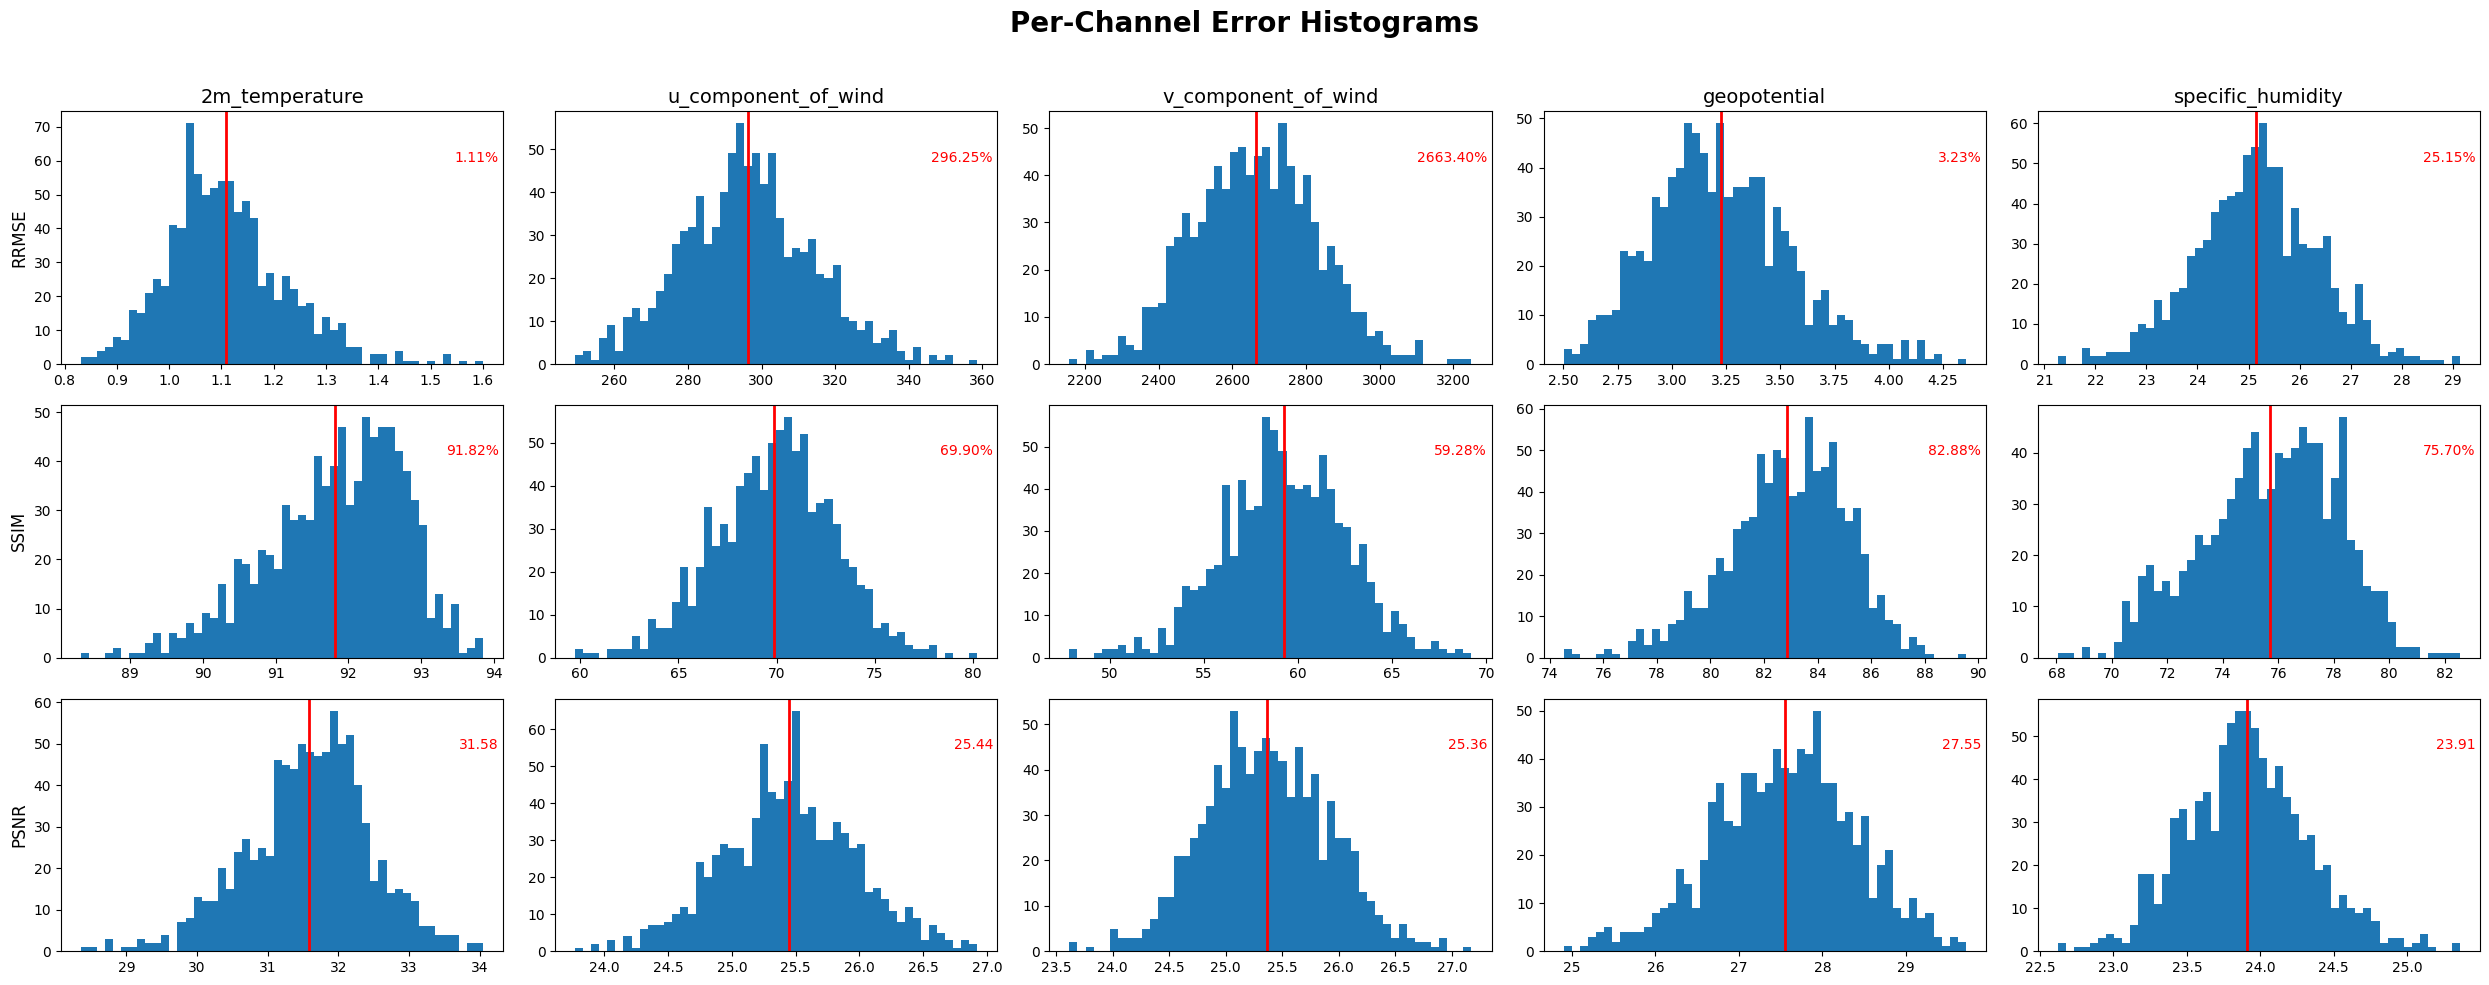

In [10]:
# 70% Mask Ratio Plots
test_dataset = WeatherBenchDatasetWindow(
    data=test_data,
    context_length=30,
    target_length=1,
    stride=1,
    mask_prob_low=0.7,
    mask_prob_high=0.7,
)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
compute_errors(
    testloader,
    encoder_model,
    seq2seq_model,
    decoder_model,
    std,
    mean,
    train_data,
)
create_error_plots(
    testloader,
    encoder_model,
    seq2seq_model,
    decoder_model,
    std,
    mean,
    train_data,
)

RRMSE Loss: 8.62%
MSE Loss: 0.2446
Latent MSE Error: 0.00432742
Masked Normalised SSIM Loss: 75.02%
Masked Normalised PSNR Loss: 25.55
Relative Error in Latent Space: 5.72%
Relative Error in Decoded Space: 24.14%
Relative Change from Latent to Decoded MSE: 55.5273


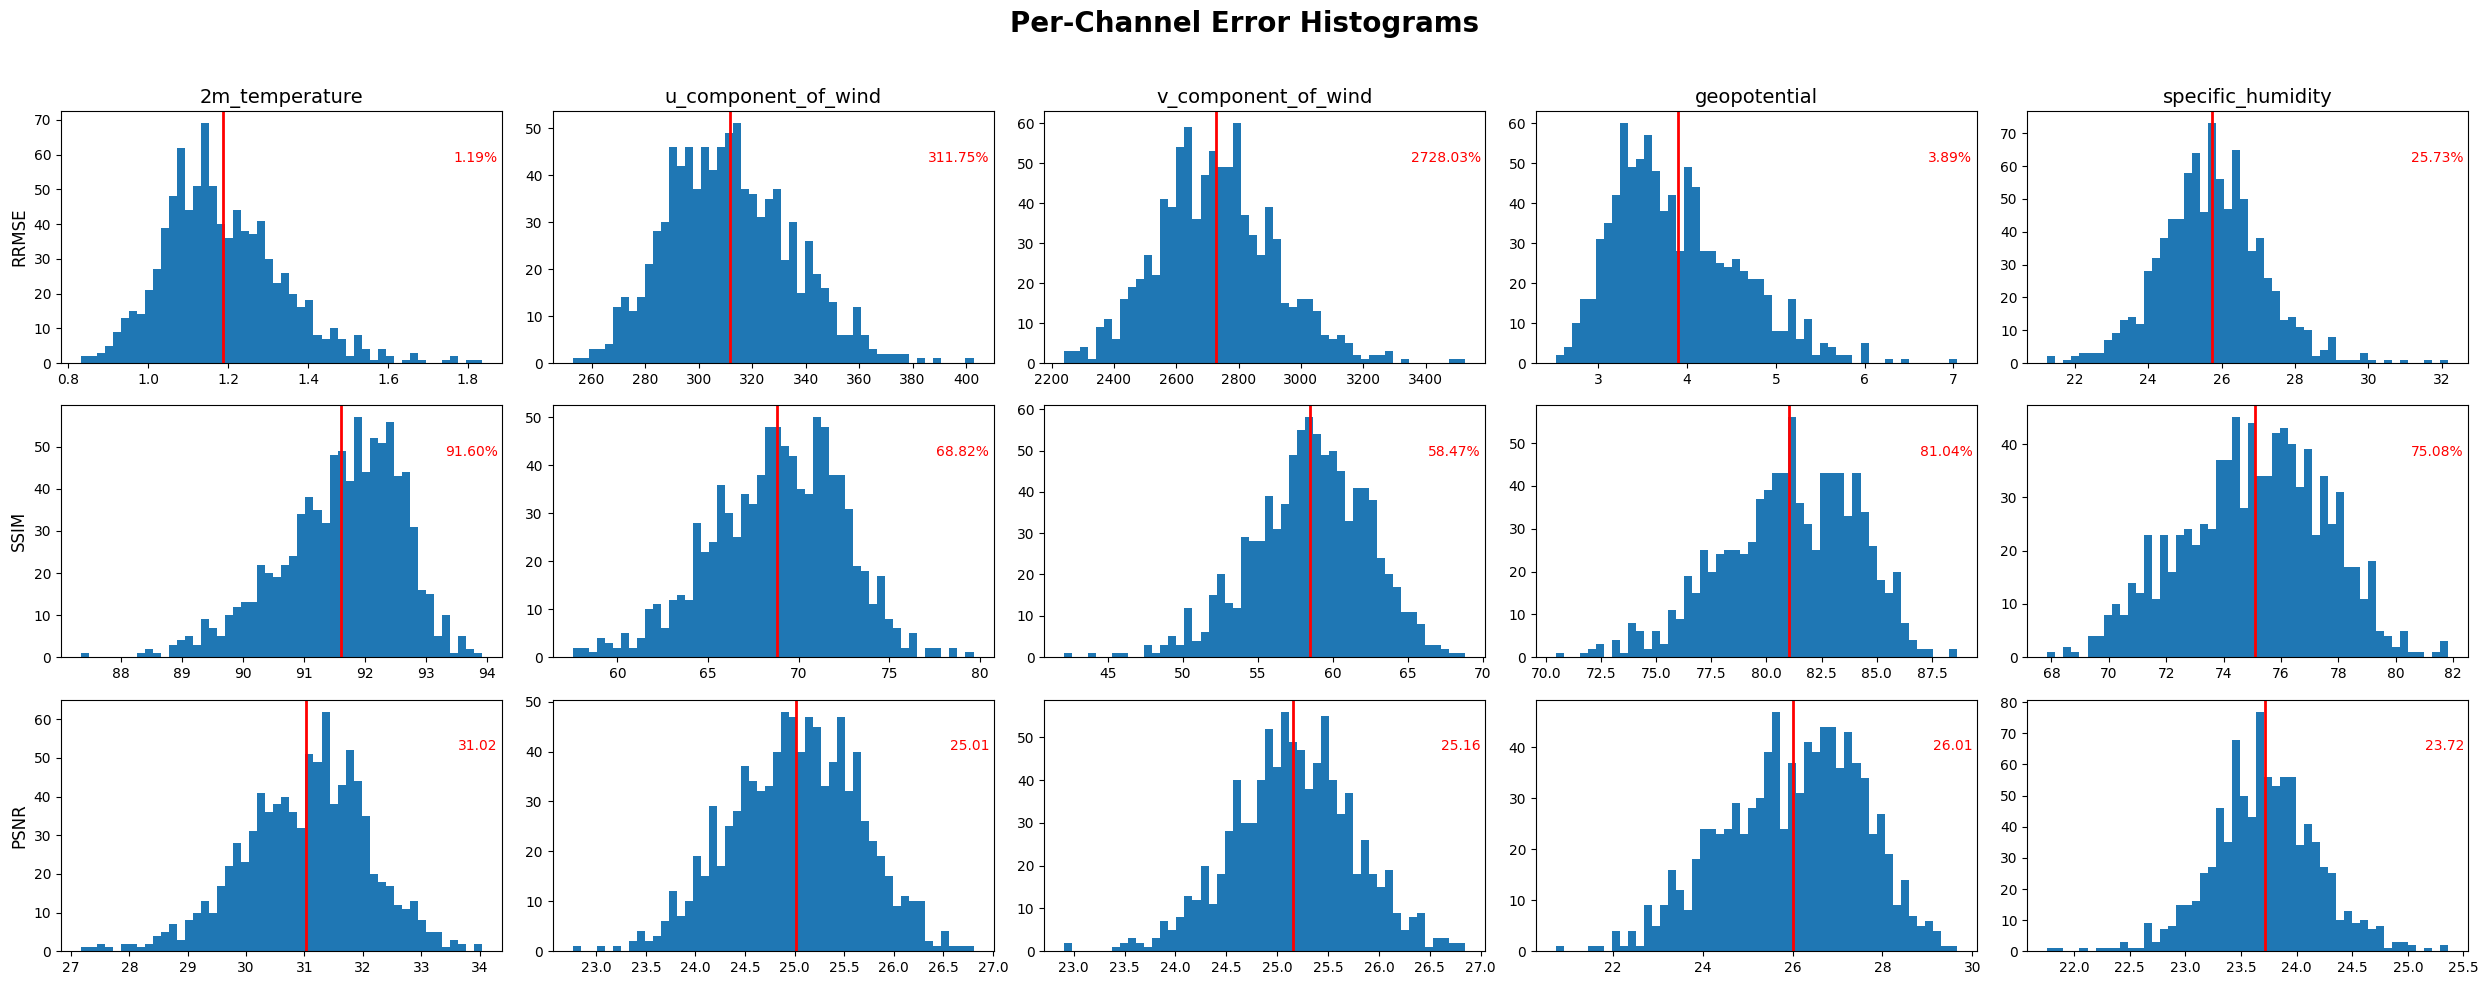

In [11]:
# 20-90% Mask Ratio Plots
test_dataset = WeatherBenchDatasetWindow(
    data=test_data,
    context_length=30,
    target_length=1,
    stride=1,
    mask_prob_low=0.2,
    mask_prob_high=0.9,
)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
compute_errors(
    testloader,
    encoder_model,
    seq2seq_model,
    decoder_model,
    std,
    mean,
    train_data,
)
create_error_plots(
    testloader,
    encoder_model,
    seq2seq_model,
    decoder_model,
    std,
    mean,
    train_data,
)

RRMSE Loss: 11.25%
MSE Loss: 0.3556
Latent MSE Error: 0.00881029
Masked Normalised SSIM Loss: 68.70%
Masked Normalised PSNR Loss: 23.52
Relative Error in Latent Space: 11.66%
Relative Error in Decoded Space: 35.03%
Relative Change from Latent to Decoded MSE: 39.3626


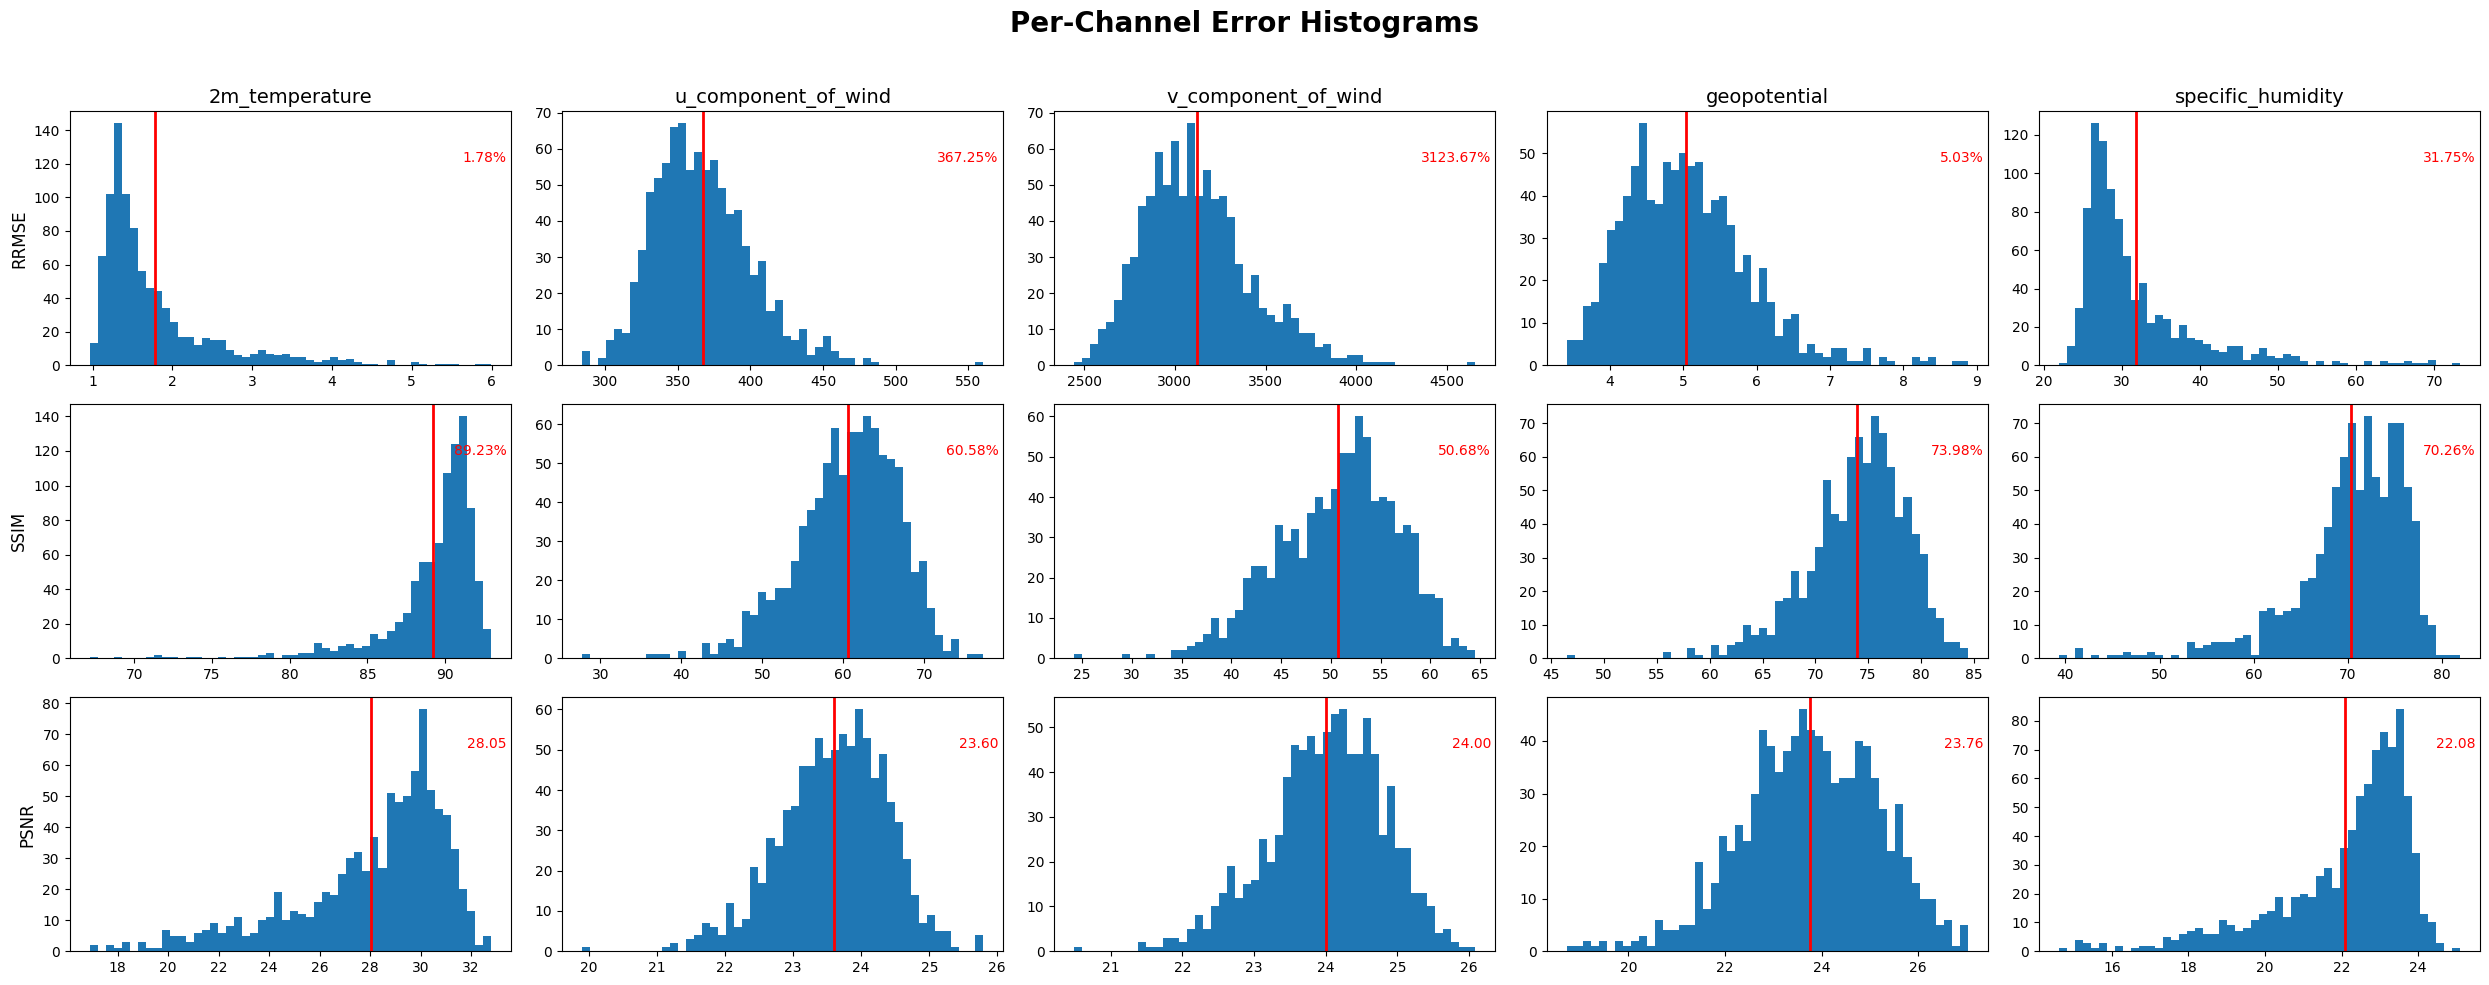

In [12]:
# Add Some Matern Noise
# 20-90% Mask Ratio Plots
test_dataset = WeatherBenchDatasetWindow(
    data=test_data,
    context_length=30,
    target_length=1,
    stride=1,
    mask_prob_low=0.2,
    mask_prob_high=0.9,
)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
compute_errors(
    testloader,
    encoder_model,
    seq2seq_model,
    decoder_model,
    std,
    mean,
    train_data,
    add_noise=True,
)
create_error_plots(
    testloader,
    encoder_model,
    seq2seq_model,
    decoder_model,
    std,
    mean,
    train_data,
    add_noise=True,
)

In [13]:
# 70% Mask Ratio Plots
test_dataset = WeatherBenchDatasetWindow(
    data=test_data,
    context_length=30,
    target_length=1,
    stride=1,
    mask_prob_low=0.7,
    mask_prob_high=0.7,
)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [14]:
batch = next(iter(testloader))
input_data = batch[0].to(DEVICE)
output_data_masked = batch[1].to(DEVICE)
output_data = batch[2].to(DEVICE)

In [15]:
with torch.no_grad():
    input_encoded_data, output_encoded_data = prepare_inputs(
        input_data, output_data_masked, encoder_model
    )
    model_pred = seq2seq_model(input_encoded_data)
    if model_pred.ndim == 2:
        model_pred = model_pred.unsqueeze(0)
    B, T, L = model_pred.shape
    model_pred = model_pred.reshape(B * T, L)
    output_encoded_data = output_encoded_data.reshape(B * T, L)
    decoded_data = decoder_model(model_pred)
    B, T, C, H, W = output_data.shape
    output_data = output_data.reshape(B * T, C, H, W)
    B, T, C, H, W = output_data_masked.shape
    output_data_masked = output_data_masked.reshape(B * T, C, H, W)

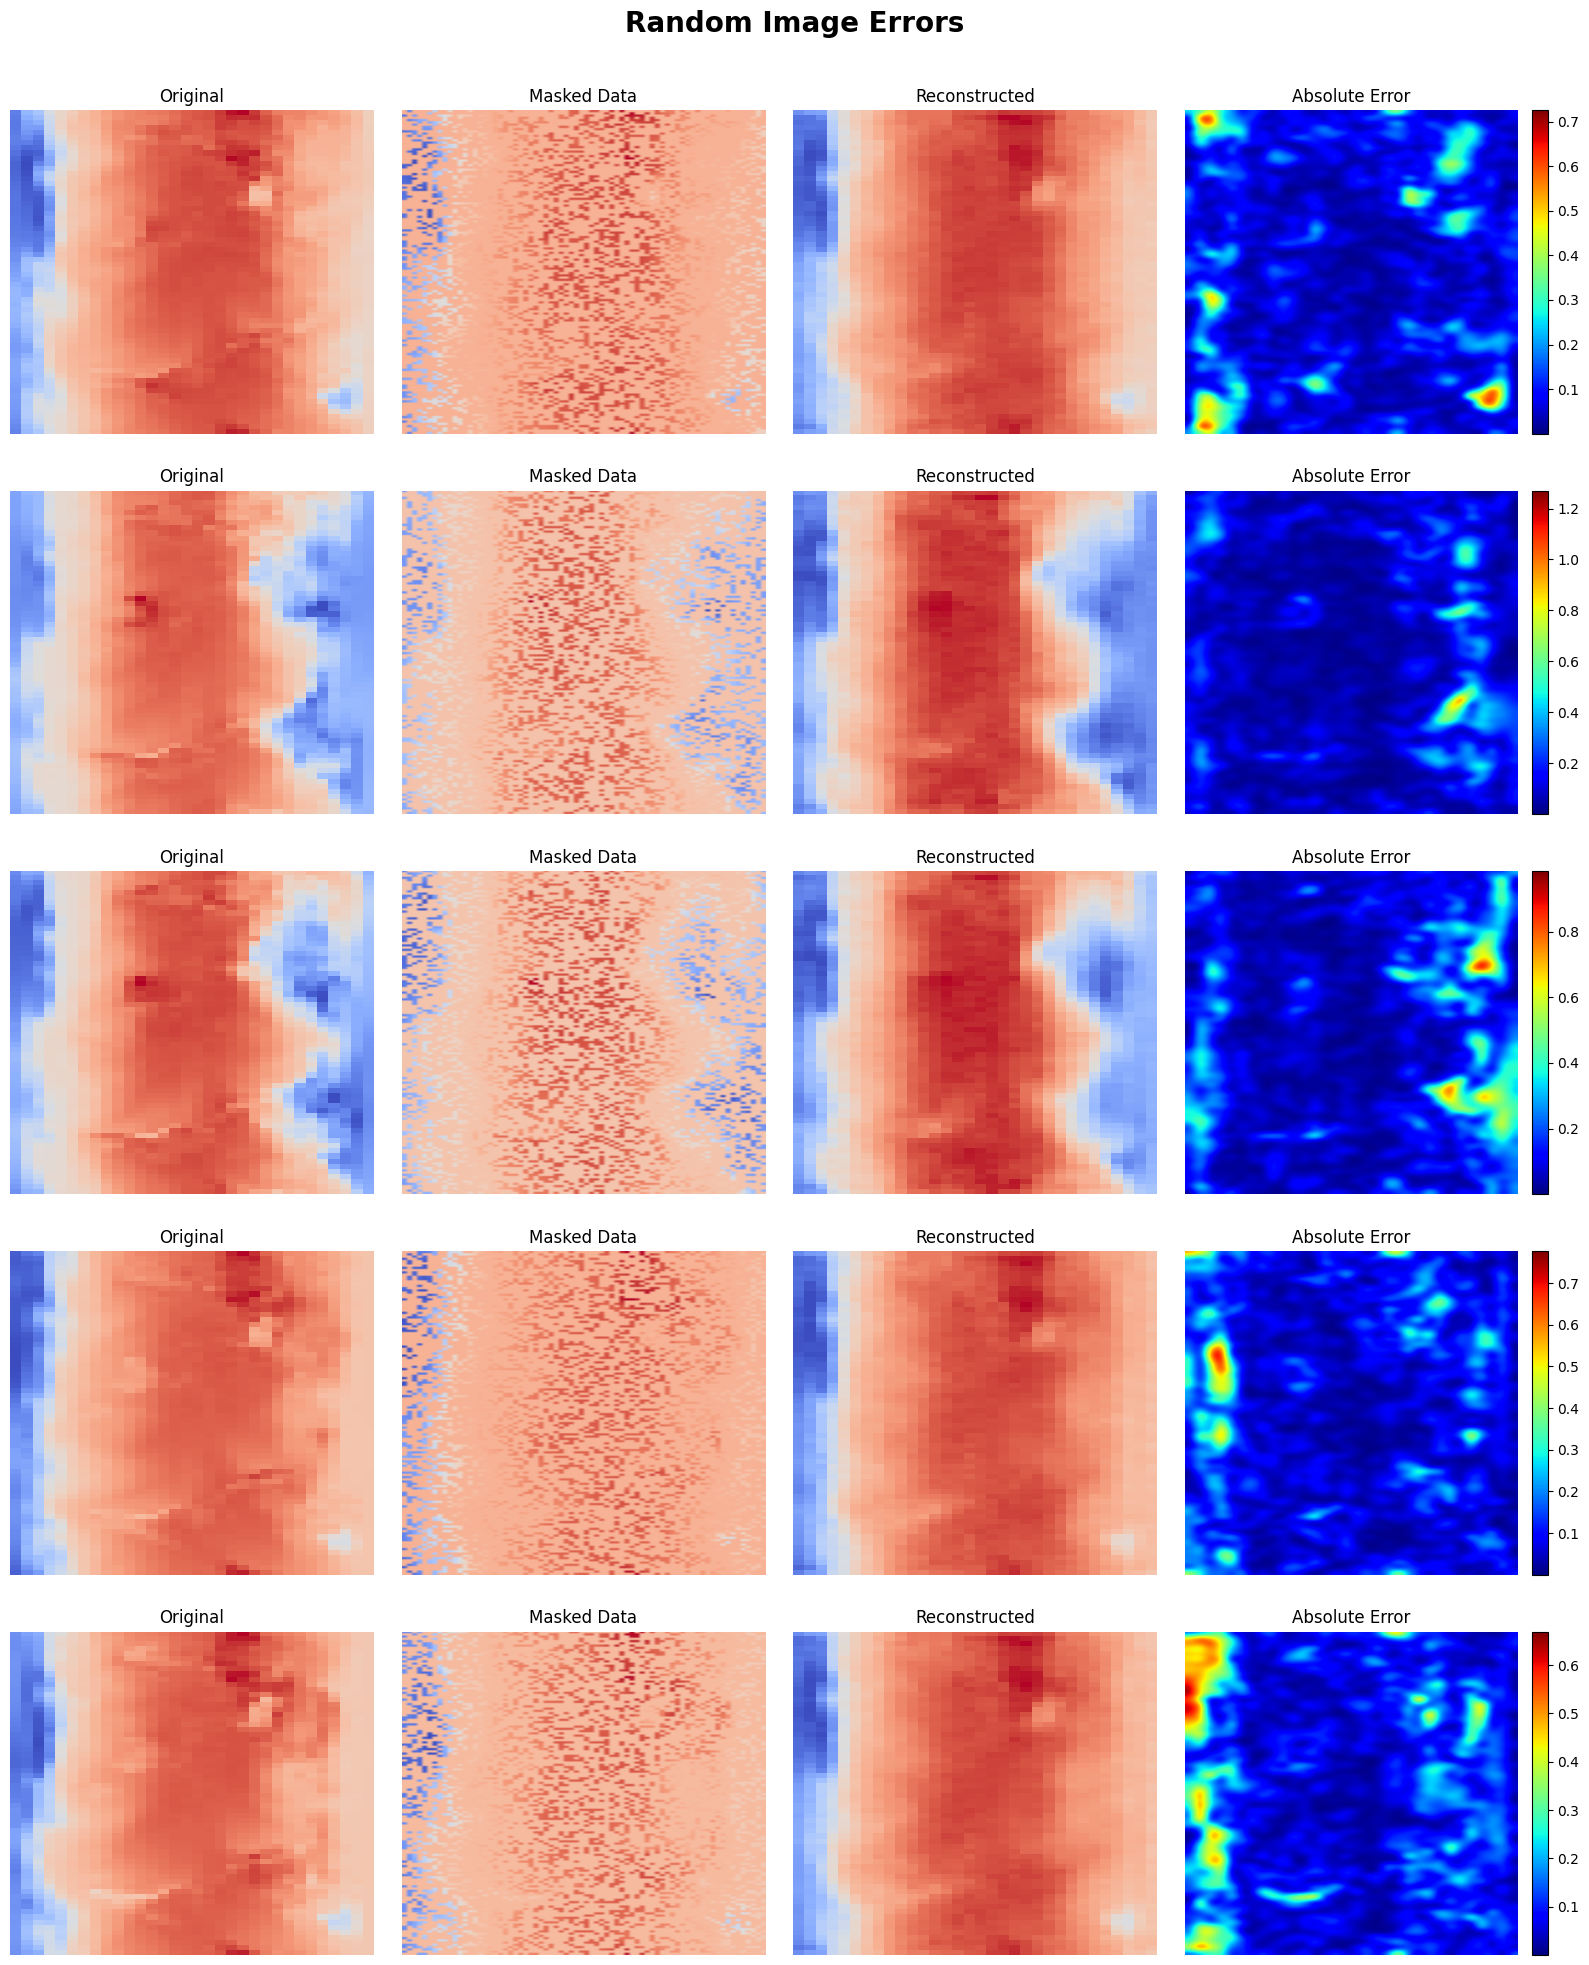

In [16]:
x_temp = (
    output_data[:, 0, :, :].unsqueeze(1).permute(0, 2, 3, 1).cpu().numpy()
)

masked_x_temp = (
    output_data_masked[:, 0, :, :]
    .unsqueeze(1)
    .permute(0, 2, 3, 1)
    .cpu()
    .numpy()
)
recon_masked_x_temp = (
    decoded_data[:, 0, :, :].unsqueeze(1).permute(0, 2, 3, 1).cpu().numpy()
)
error = np.abs(x_temp - recon_masked_x_temp)

fig, axs = plt.subplots(5, 4, figsize=(16, 20))
for i in range(5):
    x_temp_i = x_temp[i]
    masked_x_temp_i = masked_x_temp[i]
    recon_masked_x_temp_i = recon_masked_x_temp[i]
    error_i = error[i]

    axs[i, 0].imshow(x_temp_i, cmap="coolwarm", aspect="auto")
    axs[i, 0].set_title("Original")
    axs[i, 0].axis("off")

    axs[i, 1].imshow(masked_x_temp_i, cmap="coolwarm", aspect="auto")
    axs[i, 1].set_title("Masked Data")
    axs[i, 1].axis("off")

    axs[i, 2].imshow(recon_masked_x_temp_i, cmap="coolwarm", aspect="auto")
    axs[i, 2].set_title("Reconstructed")
    axs[i, 2].axis("off")

    im = axs[i, 3].imshow(
        error_i, cmap="jet", aspect="auto", interpolation="bicubic"
    )
    axs[i, 3].set_title("Absolute Error")
    axs[i, 3].axis("off")

    fig.colorbar(im, ax=axs[i, 3], fraction=0.046, pad=0.04)
fig.suptitle("Random Image Errors", fontsize=20, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.97], w_pad=2.0, h_pad=2.5)
plt.show()

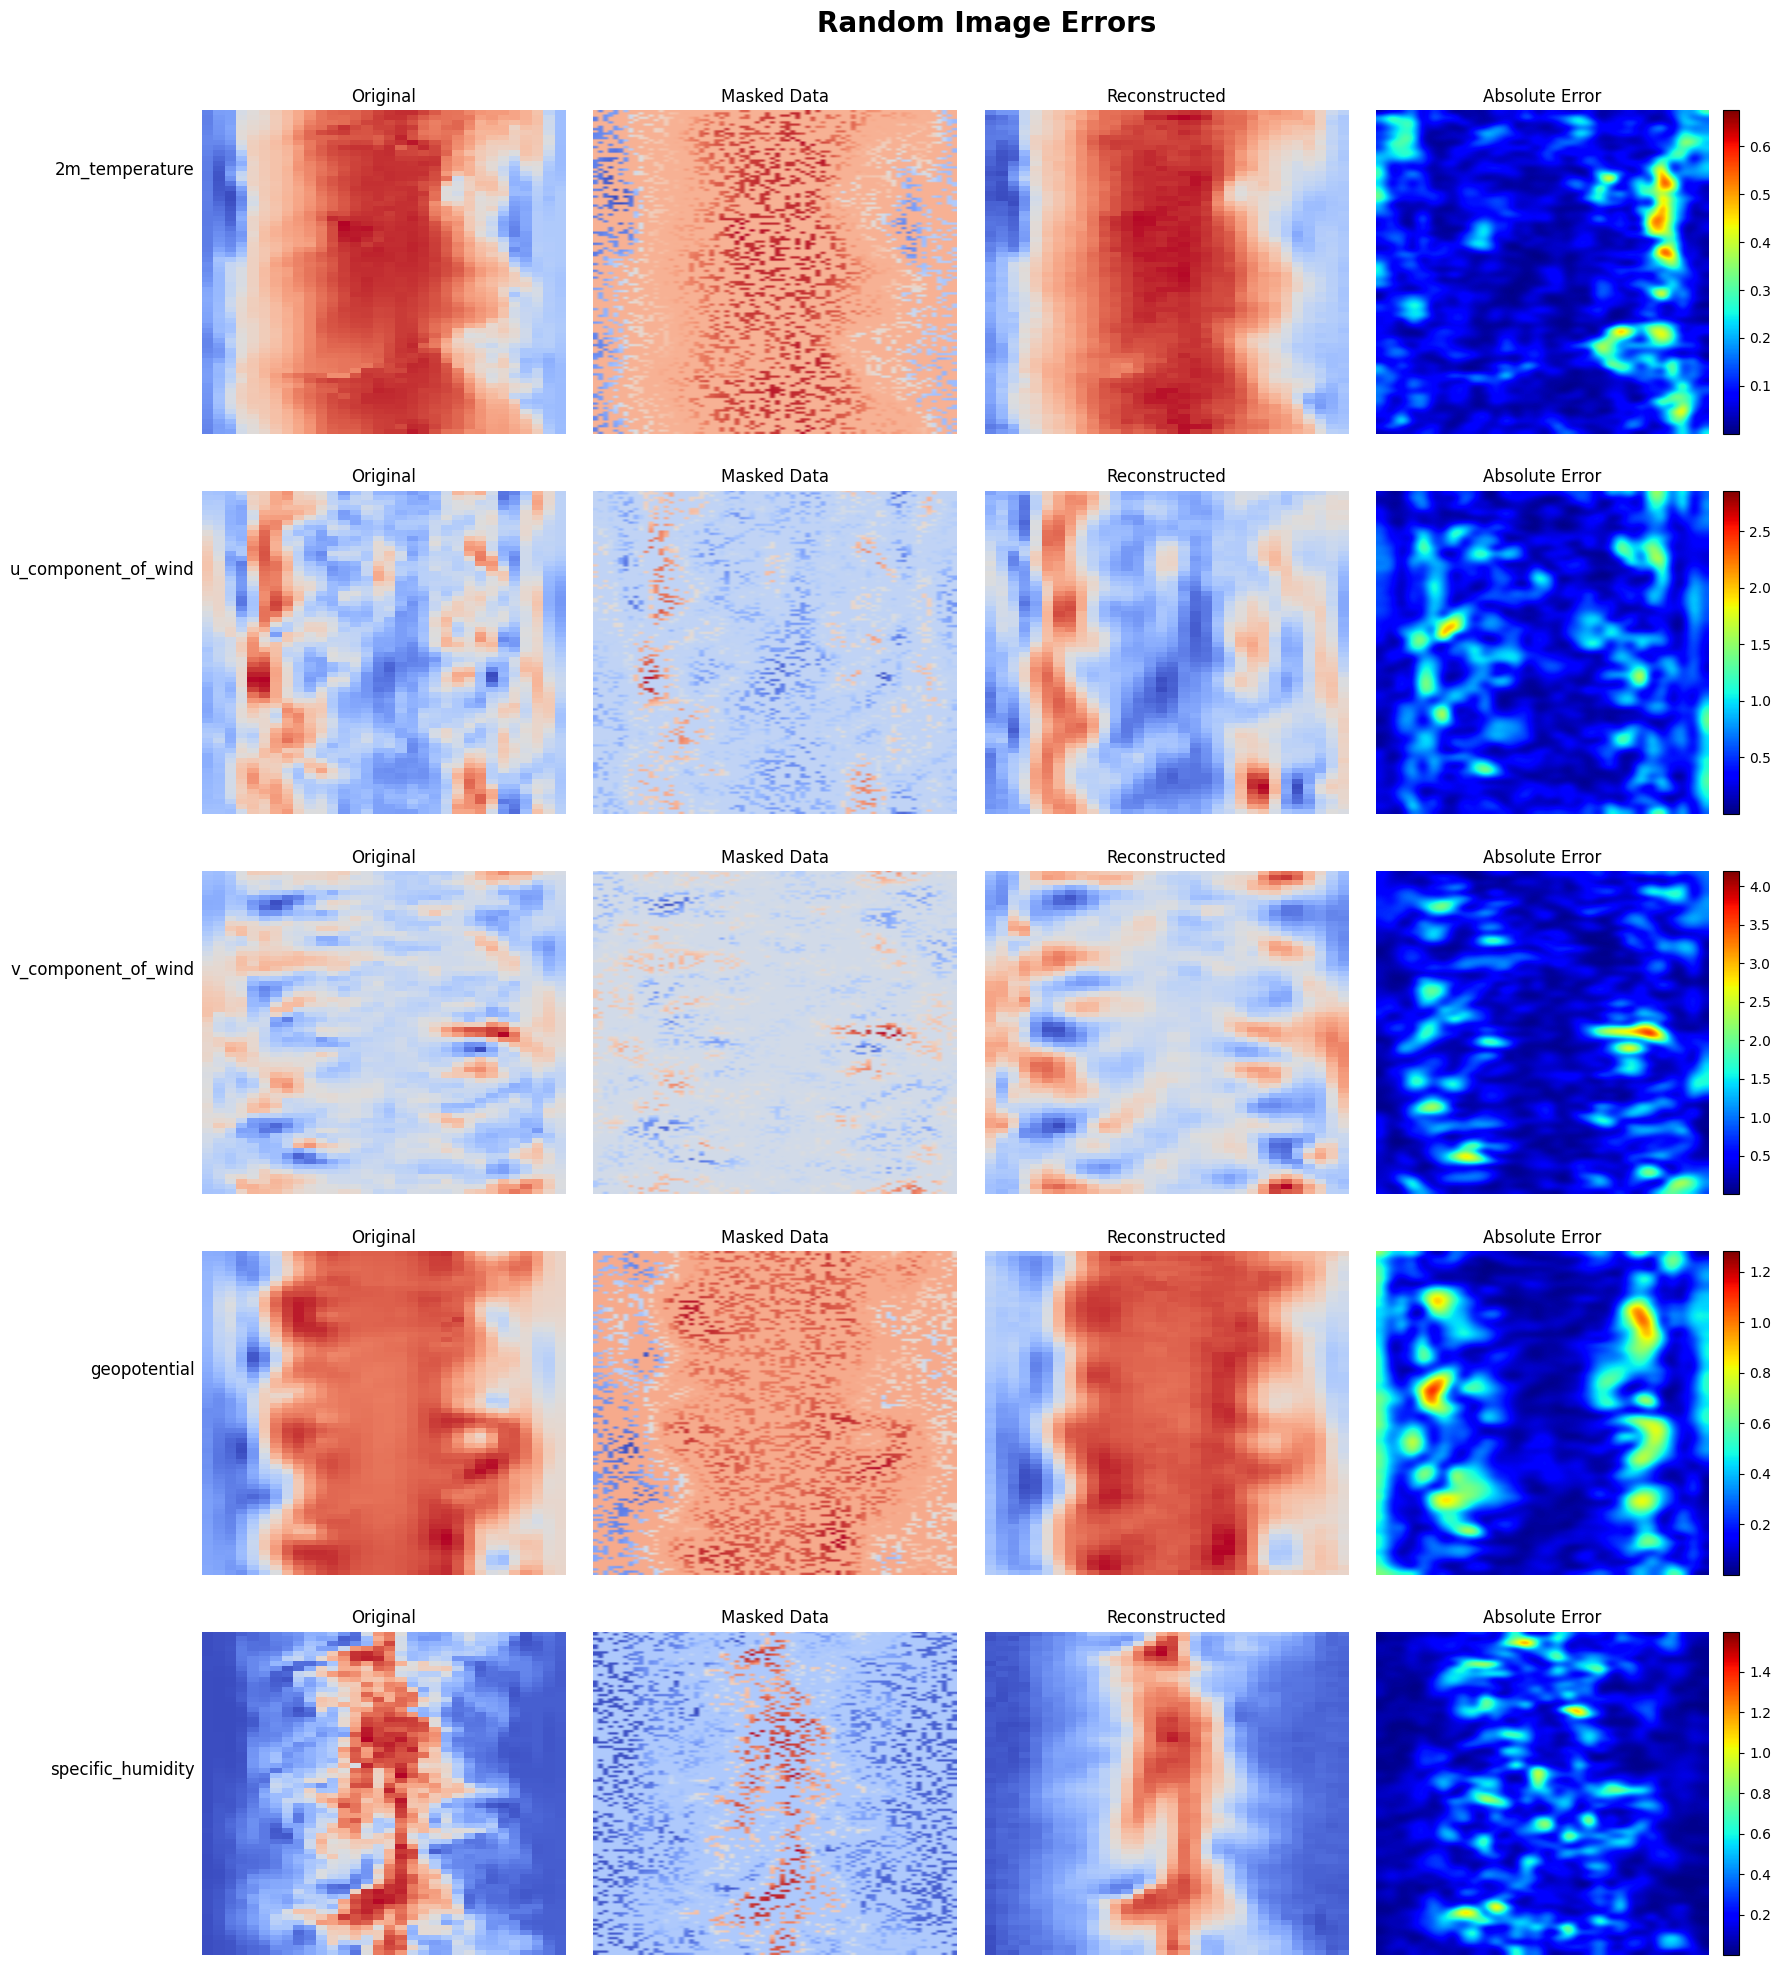

: 

In [ ]:
rng = np.random.default_rng(seed=42)
rand_int = rng.integers(0, 256)

x_temp = output_data[rand_int, :, :, :].permute(1, 2, 0).cpu().numpy()

masked_x_temp = (
    output_data_masked[rand_int, :, :, :].permute(1, 2, 0).cpu().numpy()
)
recon_masked_x_temp = (
    decoded_data[rand_int, :, :, :].permute(1, 2, 0).cpu().numpy()
)
error = np.abs(x_temp - recon_masked_x_temp)


global_min = np.min(error)
global_max = np.max(error)

mode_labels = [
    "2m_temperature",
    "u_component_of_wind",
    "v_component_of_wind",
    "geopotential",
    "specific_humidity",
]

fig, axs = plt.subplots(5, 4, figsize=(16, 20))
for i in range(5):
    x_temp_i = x_temp[:, :, i]
    masked_x_temp_i = masked_x_temp[:, :, i]
    recon_masked_x_temp_i = recon_masked_x_temp[:, :, i]
    error_i = error[:, :, i]

    axs[i, 0].imshow(x_temp_i, cmap="coolwarm", aspect="auto")
    axs[i, 0].set_title("Original")
    axs[i, 0].axis("off")

    axs[i, 1].imshow(masked_x_temp_i, cmap="coolwarm", aspect="auto")
    axs[i, 1].set_title("Masked Data")
    axs[i, 1].axis("off")

    axs[i, 2].imshow(recon_masked_x_temp_i, cmap="coolwarm", aspect="auto")
    axs[i, 2].set_title("Reconstructed")
    axs[i, 2].axis("off")

    im = axs[i, 3].imshow(
        error_i, cmap="jet", aspect="auto", interpolation="bicubic"
    )
    axs[i, 3].set_title("Absolute Error")
    axs[i, 3].axis("off")

    fig.colorbar(im, ax=axs[i, 3], fraction=0.046, pad=0.04)
fig.suptitle("Random Image Errors", fontsize=20, fontweight="bold")
for i in range(5):
    fig.text(
        0.005,
        1 - (i + 0.5) / 5,
        mode_labels[i],
        va="center",
        ha="right",
        fontsize=12,
    )
plt.tight_layout(rect=[0, 0, 1, 0.97], w_pad=2.0, h_pad=2.5)
plt.show()